In [1]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Load library

In [2]:
import io
import os
import h5py
import argparse
import torch
import time
import pickle
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from PIL import Image
from torch import nn
from torch.nn.utils import spectral_norm
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

# Check and set GPU

In [3]:
!nvidia-smi

Thu May 25 23:50:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     On   | 00000000:3B:00.0 Off |                  N/A |
| 30%   25C    P8     5W / 125W |   4471MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 4000     On   | 00000000:5E:00.0 Off |                  N/A |
| 30%   

In [4]:
cuda = torch.cuda.set_device(3)
torch.cuda.get_device_name(3)

'Quadro RTX 4000'

# Set path dataset Flowers

In [5]:
hdf5_fpath = "../flowers.hdf5"

## Distribusi dataset

In [6]:
#view contents in HDF5 files
f = h5py.File(hdf5_fpath)
print("\nData test = ",len(list(f['test'])))
print("\nData train = ",len(list(f['train'])))
print("\nData valid = ",len(list(f['valid'])))


Data test =  5775

Data train =  29390

Data valid =  5780


# Create nearest neighbor
Metode "nearest neighbor" juga dapat digunakan dalam pelatihan untuk melakukan augmentasi data. Misalnya, jika kita memiliki sejumlah deskripsi teks dan gambar yang sudah ada, kita dapat menggunakan metode "nearest neighbor" untuk mencari gambar yang paling mirip dengan deskripsi baru. Dengan memanfaatkan gambar-gambar yang mirip tersebut, kita dapat memperkaya dataset pelatihan dan meningkatkan variasi dalam pembelajaran model.

In [7]:
class NearestNeighbor:
    def __init__(self, dataset, source, cuda, ngf):
        self.dataset = dataset
        data = None
        representation = None
        labels = []
        embeddings = []
        path = ''
        data_path = path + 'dataset_{}_data.pl'.format(source)
        labels_path = path + 'dataset_{}_labels.pl'.format(source)
        nbrs_path = path + 'dataset_{}.pl'.format(source)
        embeddings_path = path + 'dataset_{}text_embeddings.pl'.format(source)
        self.model = gan_factory.generator_factory('vae', ngf, False)
        if cuda:
            self.model = self.model.cuda()
        if os.path.exists(data_path):
            print('start loading data for NN test {}'.format(data_path))
            data = pickle.load(open(data_path, 'rb'))
            labels = pickle.load(open(labels_path, 'rb'))
            nbrs = pickle.load(open(nbrs_path, 'rb'))
            embeddings = pickle.load(open(embeddings_path, 'rb'))
        else:
            print('start creating data for NN test {}'.format(data_path))
            for i, sample in enumerate(dataset):
                if data is None:
                    data = sample['right_images'].numpy()
                    data_var = Variable(sample['right_images'].float(), volatile=True)
                    if cuda:
                        data_var = data_var.cuda()
                    representation = self.model.encoder_only(data_var).data.cpu().numpy()
                    labels = sample['txt']
                    embeddings = sample['right_embed']
                else:
                    data = np.append(data, sample['right_images'].numpy(), axis=0)
                    data_var = Variable(sample['right_images'].float(), volatile=True)
                    if cuda:
                        data_var = data_var.cuda()
                    representation = np.append(representation, self.model.encoder_only(data_var).data.cpu().numpy(),
                                               axis=0)
                    labels += sample['txt']
                    embeddings = np.append(embeddings, sample['right_embed'].numpy(), axis=0)
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(representation.reshape(-1, 228))
            pickle.dump(data, open(data_path, 'wb'))
            pickle.dump(labels, open(labels_path, 'wb'))
            pickle.dump(nbrs, open(nbrs_path, 'wb'))
            pickle.dump(embeddings, open(embeddings_path, 'wb'))
        print('finish loading data for NN test')
        self.data = data
        self.labels = labels
        self.nbrs = nbrs
        self.embeddings = embeddings

    def get_text(self, samples, limit=-1):
        text_results, _, _ = self.get_text_and_images_and_embedding(samples, limit)
        return text_results

    def get_text_and_images(self, samples, limit):
        text_results, image_results, _ = self.get_text_and_images_and_embedding(samples, limit)
        return text_results, image_results

    def get_text_and_images_and_embedding(self, samples, limit=-1):
        samples_embedding = self.model.encoder_only(samples).data.cpu().numpy().reshape(-1, 228)
        if limit != -1:
            samples_embedding = samples_embedding[:limit]
        distances, indices = self.nbrs.kneighbors(samples_embedding)
        text_results = [self.labels[index] for index in indices[:, 0]]
        image_results = [self.data[index] for index in indices[:, 0]]
        embedding_results = [self.embeddings[index] for index in indices[:, 0]]
        return text_results, image_results, embedding_results

## Text to Image Phase

In [8]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    # membaca file flowers.hdf5
    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length
    
    # mengambil item untuk di training
    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        # pdb.set_trace()

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        txt = np.array(example['txt']).astype(str)
        class_ = np.array(example['class']).astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt),
                'class': str(class_)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    # mencari wrong image pada sampel 
    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)
    
    # mengambil text dari dataset
    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']

    # validasi
    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

## Concat Embedd Phase
Penggabungan antara input dengan representasi embedding dalam proses komputasi yang dilakukan oleh model yang lebih besar.

In [9]:
# embedd di projeksikan 
class Concat_embed(nn.Module):
    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
                                        nn.BatchNorm1d(num_features=projected_embed_dim),
                                        nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat

## Utils tools
Metode utilitas yang berguna dalam implementasi model seperti pemindahan variabel ke perangkat CUDA, pembuatan label yang lebih halus, penyimpanan checkpoint, dan inisialisasi bobot..

In [10]:
class Utils(object):
    def __init__(self, cuda):
        self.is_cuda = cuda

    def cuda(self, variable):
        return variable.cuda() if self.is_cuda else variable

    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset

    @staticmethod
    def save_checkpoint(netD, netG, dir_path, epoch):
        path = dir_path 
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(netD.state_dict(), '{0}/disc_{1}.pth'.format(path, epoch))
        torch.save(netG.state_dict(), '{0}/gen_{1}.pth'.format(path, epoch))
        
    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

## VAE Phase
Implementasi model VAE-GAN (Variational Autoencoder - Generative Adversarial Network) untuk generasi gambar. vae_encoder_generator bertindak sebagai pemersatu antara vae_encoder dan vae_generator, sementara vae_generator merupakan modul yang bertanggung jawab langsung untuk menghasilkan gambar berdasarkan vektor laten yang diberikan

In [11]:
class vae_encoder_generator(nn.Module):
    def __init__(self, ngf):
        super(vae_encoder_generator, self).__init__()
        self.vae_encoder = vae_encoder(ngf)
        self.vae_generator = vae_generator(ngf)

    def forward(self, inp):
        x = self.vae_encoder(inp)
        x = self.vae_generator(x)
        return x

    def generator_only(self, latent):
        return self.vae_generator(latent)

    def encoder_only(self, inp):
        return self.vae_encoder(inp.cuda())


class vae_generator(nn.Module):
    def __init__(self, ngf):
        super(vae_generator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.noise_dim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = ngf

        # based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True), # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True), # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True), # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (num_channels) x 64 x 64
        )

    def forward(self, latent_vector):
        # projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        # latent_vector = torch.cat([projected_embed, z], 1)
        latent_vector = latent_vector.view(-1, self.latent_dim, 1, 1)
        #print("**** latent_vector is cuda = ",latent_vector.cpu().is_cuda)
        output = self.netG(latent_vector.cpu())

        return output

## VAE Encoder Phase
Implementasi model VAE-GAN (Variational Autoencoder - Generative Adversarial Network). vae_encoder bertanggung jawab untuk mengubah gambar menjadi vektor laten, sementara vae_discriminator bertanggung jawab untuk membedakan antara gambar asli dan gambar yang dihasilkan oleh generator.

In [12]:
class vae_encoder(nn.Module):
    def __init__(self, ngf):
        super(vae_encoder, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        self.noise_dim = 100
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = ngf

        self.projection = nn.Sequential(nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim), nn.LeakyReLU(negative_slope=0.2, inplace=True))

        self.netE = nn.Sequential(
            # state size. (num_channels) x 64 x 64
            nn.Conv2d(self.num_channels, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.Conv2d(self.ngf, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.Conv2d(self.ngf * 2, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.Conv2d(self.ngf * 4, self.ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.latent_dim, 4, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, images):
        output = self.netE(images)
        #print(output.is_cuda)
        return output


class vae_discriminator(nn.Module):
    def __init__(self, remove_noise):
        super(discriminator, self).__init__()
        self.image_size = 64
        self.num_channels = 128
        self.embed_dim = 1024
        if remove_noise:
            self.projected_embed_dim = 228
            self.noise_dim = 0
        else:
            self.projected_embed_dim = 128
            self.noise_dim = 100
        self.B_dim = 128
        self.C_dim = 16
        self.minibatch_discriminator = minibatch_discriminator(self.num_channels, self.B_dim, self.C_dim)
        #
        self.netD_1 = nn.Sequential(
            nn.Linear(self.projected_embed_dim + self.noise_dim, 228),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(228, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.netD_2 = nn.Sequential(
            nn.Linear(128 + self.B_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, inp):
        x = inp.view(-1, self.projected_embed_dim + self.noise_dim)
        x = self.netD_1(x)
        x = self.minibatch_discriminator(x)
        x = self.netD_2(x)

        return x.view(-1)

## Generative Adversarial Network side
Menggunakan arsitektur LSGAN

In [13]:
class generator(nn.Module):
    def __init__(self, remove_noise, variational):
        super(generator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        self.remove_noise = remove_noise
        if remove_noise:
            self.noise_dim = 0
            self.projected_embed_dim = 228
        else:
            self.noise_dim = 100
            self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = 64
        self.variational = variational
        self.mu = None
        self.sd = None

        self.projection = nn.Sequential(nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim), nn.LeakyReLU(negative_slope=0.2, inplace=True))

        if variational:
            self.en_mu = nn.Conv2d(self.projected_embed_dim, self.projected_embed_dim, 1, 1, 0)
            self.en_sigma = nn.Conv2d(self.projected_embed_dim, self.projected_embed_dim, 1, 1, 0)
            self.softplus = nn.Softplus()
            self.en_mu.weight.data.normal_(0, 0.002)
            self.en_mu.bias.data.normal_(0, 0.002)
            self.en_sigma.weight.data.normal_(0, 0.002)
            self.en_sigma.bias.data.normal_(0, 0.002)

        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8), 
            nn.ReLU(True), 
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True), 
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True), 
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(self.ngf), 
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False), 
            nn.Tanh()
            # state size. (num_channels) x 64 x 64
        )

    def forward(self, embed_vector, z, noise):
        return self.netG(self.encoder_only(embed_vector, z, noise))

    def encoder_only(self, embed_vector, z, noise):
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        if self.variational:
            self.mu = self.en_mu(projected_embed)
            self.sd = self.softplus(self.en_sigma(projected_embed))
            projected_embed = self.mu + self.sd.mul(noise)
        if self.remove_noise:
            latent_vector = projected_embed
        else:
            latent_vector = torch.cat([projected_embed, z], 1)
        return latent_vector

    def generator_only(self, latent_vector):
        return self.netG(latent_vector)


class discriminator(nn.Module):
    def __init__(self, remove_noise):
        super(discriminator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        if remove_noise:
            self.projected_embed_dim = 228
        else:
            self.projected_embed_dim = 128
        self.ndf = 64
        self.B_dim = 128
        self.C_dim = 16

        self.netD_1 = nn.Sequential(
            spectral_norm(nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True))

        self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            spectral_norm(nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False), 
                          ), nn.Sigmoid())

    def forward(self, inp, embed):
        x_intermediate = self.netD_1(inp)
        x = self.projector(x_intermediate, embed)
        x = self.netD_2(x)

        return x.view(-1, 1).squeeze(1), x_intermediate


## Remove Noise by Variational Encoder

In [14]:
class gan_factory(object):
    @staticmethod
    def generator_factory(type, ngf, remove_noise, variational=False):
        if type == 'gan':
            return generator(remove_noise, variational)
        elif type == 'vae':
            return vae_encoder_generator(ngf)

    @staticmethod
    def discriminator_factory(type, remove_noise):
        if type == 'gan':
            return discriminator(remove_noise)
        elif type == 'vae':
            return vae_discriminator(remove_noise)

## Training Phase 
Termasuk proses train dan test model

In [19]:
class Trainer(object):
    def __init__(self, type, dataset, split, lr, diter, save_path, l1_coef, l2_coef, batch_size, num_workers, epochs, args, params_search=False):
        self.config = args
        self.cuda = torch.cuda.is_available()

        self.generator = gan_factory.generator_factory(type, args.ngf, args.remove_noise_2, args.variational)
        self.discriminator = gan_factory.discriminator_factory(type, args.remove_noise_2)

        self.target_generator = gan_factory.generator_factory(args.target_type, args.ngf, args.remove_noise_2)
        
        if self.cuda:
            self.generator = self.generator.cuda()
            self.discriminator = self.discriminator.cuda()

        if dataset == 'flowers_only':
            self.dataset = Text2ImageDataset(self.config.flowers_dataset_path, split=0)
            self.target_dataset = Text2ImageDataset(self.config.flowers_dataset_path, split=2)
        else:
            print('Dataset not supported, please select either birds, flowers or flowers_only.')
            exit()

        self.noise_dim = 100
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.beta1 = 0.5
        self.num_epochs = epochs
        self.DITER = diter

        self.l1_coef = l1_coef
        self.l2_coef = l2_coef

        self.data_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True,
                                      num_workers=self.num_workers)
        self.target_data_loader = DataLoader(self.target_dataset, batch_size=self.batch_size, shuffle=True,
                                             num_workers=self.num_workers)

        self.optimD = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.optimG = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))

        self.save_path = save_path
        self.type = type
        
        self.args = args
        if not params_search:
            self.checkpoints_path = 'lsgan_tmp/'
            if not os.path.exists(self.checkpoints_path):
                os.makedirs(self.checkpoints_path)
            print("=== Calling Nearest Neighbour ===")
            self.nn = NearestNeighbor(self.target_data_loader, dataset, self.cuda, args.ngf)
        self.params_search = params_search
        
    def train(self, cls=False):
        print("=== Inside train() func ===")
        if self.type == 'gan':
            self._train_gan(cls)
        
    def _train_gan(self, cls):
        print("=== Start training LSGAN with Spectral Normalization ===")
        criterion = nn.MSELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        iteration = 0
        

        for epoch in range(self.num_epochs):
            for sample in self.data_loader:
                iteration += 1
                right_images = sample['right_images']
                right_embed = sample['right_embed']
                wrong_images = sample['wrong_images']

                right_images = Variable(right_images.float()).cuda()
                right_embed = Variable(right_embed.float()).cuda()
                wrong_images = Variable(wrong_images.float()).cuda()

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

                real_labels = Variable(real_labels).cuda()
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()

                # Train the discriminator
                self.discriminator.zero_grad()
                outputs, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                if cls:
                    outputs, _ = self.discriminator(wrong_images, right_embed)
                    wrong_loss = criterion(outputs, fake_labels)
                    wrong_score = outputs

                if self.args.remove_noise:
                    noise = Variable(torch.zeros(right_images.size(0), self.noise_dim)).cuda()
                else:
                    noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise, noise)
                outputs, _ = self.discriminator(fake_images, right_embed)
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                d_loss = real_loss + fake_loss

                if cls:
                    d_loss = d_loss + wrong_loss

                d_loss.backward()
                self.optimD.step()

                # Train the generator
                self.generator.zero_grad()
                if self.args.remove_noise:
                    noise = Variable(torch.zeros(right_images.size(0), self.noise_dim)).cuda()
                else:
                    noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                g_loss = criterion(outputs, real_labels) +\
                         self.l2_coef * l2_loss(activation_fake, activation_real.detach()) +\
                         self.l1_coef * l1_loss(fake_images, right_images)

                g_loss.backward()
                self.optimG.step()

                if iteration % 10 == 0:
                    print("Epoch %d | iter %d, d_loss= %f, g_loss= %f, ccaD(X)= %f, D(G(X))= %f" % (epoch, iteration, d_loss.data.cpu().mean(), g_loss.data.cpu().mean(), real_score.data.cpu().mean(), fake_score.data.cpu().mean()))

            if (epoch) % 10 == 0:
                Utils.save_checkpoint(self.discriminator, self.generator, self.save_path, epoch)
                
    def test(self):
        self.generator.eval()
        self.target_generator.eval()
        
        number_of_images = 2
        sample = next(iter(self.data_loader))
        all_nn_texts = []
        all_nn_images = []
        all_fake_sources = []
        all_transfers = []
        text = sample['txt']
        right_images = sample['right_images']
        right_embed = sample['right_embed']
        for i in range(number_of_images):
            right_images_v = Variable(right_images.float(), volatile=True)
            right_embed_v = Variable(right_embed.float(), volatile=True)
            if self.args.remove_noise:
                noise = Variable(torch.zeros(right_images_v.size(0), self.noise_dim), volatile=True)
            else:
                noise = Variable(torch.randn(right_images_v.size(0), self.noise_dim), volatile=True)
            if self.cuda:
                right_embed_v = right_embed_v.cuda()
                noise = noise.cuda()

            noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
            fake_target = self.target_generator.generator_only(self.generator.encoder_only(right_embed_v, noise, noise))
            all_transfers.append(fake_target)
            fake_source = self.generator(right_embed_v, noise,noise)
            all_fake_sources.append(fake_source)
            
            fake_source = fake_source.cuda()
            print("fake_source shape: ",fake_source.detach().shape)
            print("text description: ",text[0])
            plt.imshow(fake_source[0].cpu().detach().permute(1, 2, 0))
            plt.show()

            nn_text, nn_images = self.nn.get_text_and_images(fake_target, -1)
            all_nn_texts.append(nn_text)
            all_nn_images.append(nn_images)

        print("=== end of testing ===")
        
    def test_custom(self, txt):
        self.generator.eval()
        self.target_generator.eval()

        number_of_images = 2
        sample = next(iter(self.data_loader))
        all_nn_texts = []
        all_nn_images = []
        all_fake_sources = []
        all_transfers = []
        text = txt
        right_images = sample['right_images']
        right_embed = sample['right_embed']
        for i in range(number_of_images):
            right_images_v = Variable(right_images.float(), volatile=True)
            right_embed_v = Variable(right_embed.float(), volatile=True)
            if self.args.remove_noise:
                noise = Variable(torch.zeros(right_images_v.size(0), self.noise_dim), volatile=True)
            else:
                noise = Variable(torch.randn(right_images_v.size(0), self.noise_dim), volatile=True)
            if self.cuda:
                right_embed_v = right_embed_v.cuda()
                noise = noise.cuda()

            noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
            fake_target = self.target_generator.generator_only(self.generator.encoder_only(right_embed_v, noise, noise))
            all_transfers.append(fake_target)
            fake_source = self.generator(right_embed_v, noise,noise)
            all_fake_sources.append(fake_source)

            fake_source = fake_source.cuda()
            print("fake_source shape: ",fake_source.detach().shape)
            print("text description: ",text[0])
            plt.imshow(fake_source[0].cpu().detach().permute(1, 2, 0))
            plt.show()

            nn_text, nn_images = self.nn.get_text_and_images(fake_target, -1)
            all_nn_texts.append(nn_text)
            all_nn_images.append(nn_images)

        print("=== end of testing ===")

## Running Phase

=== Calling Nearest Neighbour ===
start loading data for NN test dataset_flowers_only_data.pl
finish loading data for NN test
=== Inside train() func ===
=== Start training LSGAN with Spectral Normalization ===
Epoch 0 | iter 10, d_loss= 0.068740, g_loss= 35.567368, ccaD(X)= 0.805576, D(G(X))= 0.150608
Epoch 0 | iter 20, d_loss= 0.021965, g_loss= 32.363411, ccaD(X)= 0.913216, D(G(X))= 0.112247
Epoch 0 | iter 30, d_loss= 0.085724, g_loss= 29.069933, ccaD(X)= 0.729369, D(G(X))= 0.053529
Epoch 0 | iter 40, d_loss= 0.131816, g_loss= 26.884962, ccaD(X)= 0.867796, D(G(X))= 0.168631
Epoch 0 | iter 50, d_loss= 0.028663, g_loss= 25.892033, ccaD(X)= 0.859153, D(G(X))= 0.071099
Epoch 0 | iter 60, d_loss= 0.058671, g_loss= 25.503160, ccaD(X)= 0.761343, D(G(X))= 0.037136
Epoch 0 | iter 70, d_loss= 0.020818, g_loss= 24.438543, ccaD(X)= 0.871130, D(G(X))= 0.093378
Epoch 0 | iter 80, d_loss= 0.052164, g_loss= 24.224463, ccaD(X)= 0.926931, D(G(X))= 0.137339
Epoch 0 | iter 90, d_loss= 0.163593, g_loss= 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake_source shape:  torch.Size([128, 3, 64, 64])
text description:  the petals on this flower are white with an elaborate pistil.



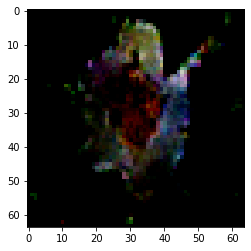

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake_source shape:  torch.Size([128, 3, 64, 64])
text description:  the petals on this flower are white with an elaborate pistil.



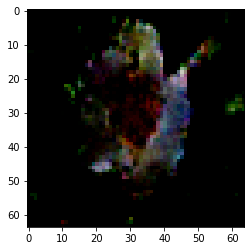

=== end of testing ===
Running LSGAN-SN took 6:13:35


In [16]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
parser = argparse.ArgumentParser()
params = dict()

params['type']='gan'
params['target_type']='vae'
params['lr']=0.0002
params['l1_coef']=50
params['l2_coef']=100
params['diter']=5
params['cls']=False
params['save_path']='lsgan_tmp/'
params['inference']=False
params['target_train']=False
params['dataset']='flowers_only'
params['split']=0
params['batch_size']=128
params['num_workers']=1
params['ngf']=64
params['epochs']=51
params['variational']=False
params['flowers_dataset_path']="../flowers.hdf5"
params['remove_noise']=False
params['remove_noise_2']=False

args = Struct(**params)

trainer = Trainer(type=args.type, dataset=args.dataset, split=args.split, lr=args.lr, diter=args.diter, save_path=args.save_path, l1_coef=args.l1_coef, 
                  l2_coef=args.l2_coef,batch_size=args.batch_size, num_workers=args.num_workers, epochs=args.epochs, args=args)

start_time = time.time()

if not args.inference:
    if args.target_train:
        trainer.target_train(args.cls)
    else:
        trainer.train(args.cls)
print("=== Testing ===")
trainer.test()

elapsed = str(timedelta(seconds=int(time.time() - start_time)))
print('Running {} took {}'.format("LSGAN-SN", elapsed))

=== Testing ===


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


fake_source shape:  torch.Size([128, 3, 64, 64])
text description:  this pink flower has many rows of overlapping petals with the prominent yellow stamens at the center



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


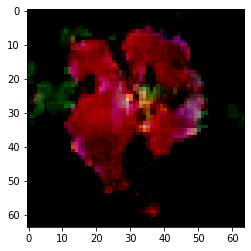

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake_source shape:  torch.Size([128, 3, 64, 64])
text description:  this pink flower has many rows of overlapping petals with the prominent yellow stamens at the center



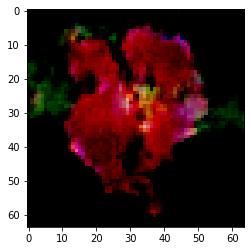

=== end of testing ===


In [17]:
print("=== Testing ===")
trainer.test()

## Visualization side

In [29]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 102 kB/s            
     |████████████████████████████████| 502 kB 13.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


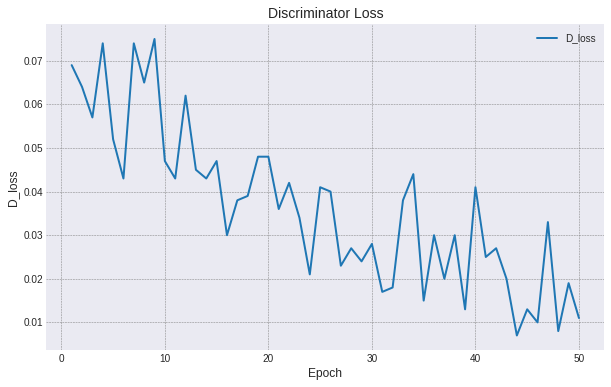

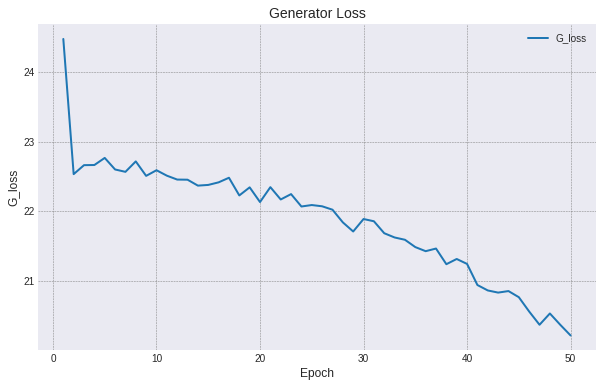

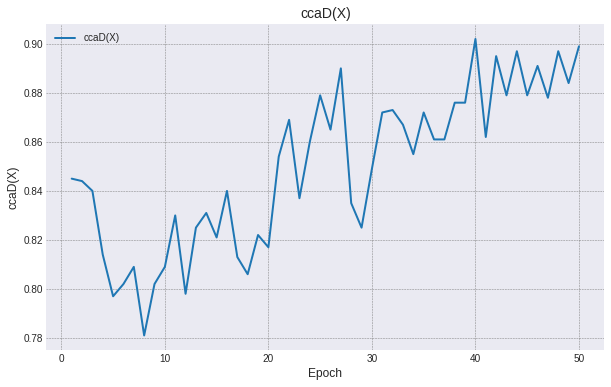

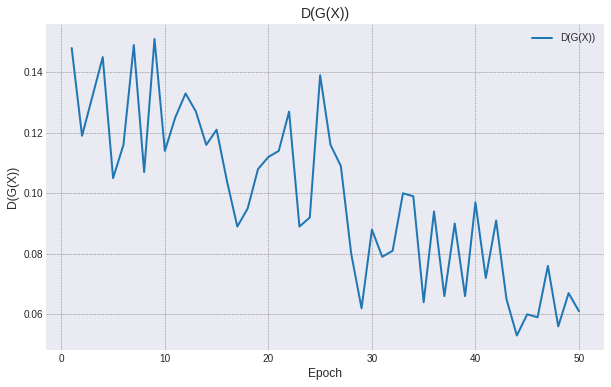

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari file CSV
data = pd.read_csv('result_v2.csv')

# Mengambil nilai dari kolom-kolom yang ingin ditampilkan
epoch = data['epoch']
d_loss = data['d_loss']
g_loss = data['g_loss']
ccaD_X = data['ccaD(X)']
D_G_X = data['D(G(X))']

# Membuat figure dan axes
fig, ax = plt.subplots()

# Mengatur style grafik
plt.style.use('seaborn-darkgrid')

# Membuat figure dan axes untuk D_loss
ax.plot(epoch, d_loss, label='D_loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('D_loss', fontsize=12)
plt.title('Discriminator Loss', fontsize=14)
plt.legend(fontsize=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Membuat figure dan axes untuk G_loss
fig, ax = plt.subplots()
ax.plot(epoch, g_loss, label='G_loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('G_loss', fontsize=12)
plt.title('Generator Loss', fontsize=14)
plt.legend(fontsize=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Membuat figure dan axes untuk ccaD(X)
fig, ax = plt.subplots()
ax.plot(epoch, ccaD_X, label='ccaD(X)', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ccaD(X)', fontsize=12)
plt.title('ccaD(X)', fontsize=14)
plt.legend(fontsize=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Membuat figure dan axes untuk D(G(X))
fig, ax = plt.subplots()
ax.plot(epoch, D_G_X, label='D(G(X))', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('D(G(X))', fontsize=12)
plt.title('D(G(X))', fontsize=14)
plt.legend(fontsize=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()